This notebook is used to train a CNN model to classify HA sequences of Influenza A H1N\*, H3N\*, H5N\* and H7N\* subtypes.

### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# FOR COLAB NOTEBOOKS

# Code for colab to mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the path to your zip file and the target directory for extraction
data_directory = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results'

# Load the numpy arrays with allow_pickle=True
cnn_labels = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results/cnn_labels.npy', allow_pickle=True)
cnn_sequences = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results/cnn_sequences.npy', allow_pickle=True)
cnn_accessions = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results/cnn_accessions.npy', allow_pickle=True)
processed_dna_sequences = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results/processed_dna_sequences.csv'

### Encode the labels

Required:

1. cnn_labels

In [7]:
# --- 1. Encode string labels to numerical format and then to one-hot encoded vectors ---
# This part is crucial before training your model.
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(cnn_labels)
num_classes = len(label_encoder.classes_) # Get the total number of unique HA types

# Convert integer labels to one-hot encoded vectors
one_hot_labels = to_categorical(integer_encoded_labels, num_classes=num_classes)

print(f"Original labels (first 5): {cnn_labels[:5]}")
print(f"Integer encoded labels (first 5): {integer_encoded_labels[:5]}")
print(f"Classes: {label_encoder.classes_}")
print(f"One-hot encoded labels (first 5):\n{one_hot_labels[:5]}")
print(f"Shape of one-hot encoded labels: {one_hot_labels.shape}")

Original labels (first 5): ['HA3' 'HA3' 'HA3' 'HA3' 'HA3']
Integer encoded labels (first 5): [1 1 1 1 1]
Classes: ['HA1' 'HA3' 'HA5' 'HA7']
One-hot encoded labels (first 5):
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
Shape of one-hot encoded labels: (667, 4)


### Create Training, Validation, Test sets

Requirements

1. cnn_sequences (vectorized DNA sequences)

In [8]:
# --- 2. Split data into training, validation, and test sets ---
# Example: 70% train, 15% validation, 15% test
# Add an extra dimension to cnn_sequences to make it (samples, height, width, channels)
# For Conv2D, we typically treat (sequence_length, features) as (height, width, channels)
# so we add a width of 1: (samples, sequence_length, 1, features)
# The input shape to Conv2D will then be (sequence_length, 1, features)
X_reshaped = np.expand_dims(cnn_sequences, axis=2) # Add a new dimension at index 2 (width)
# Now X_reshaped shape is (num_samples, 1820, 1, 4)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_reshaped, one_hot_labels, test_size=0.3, random_state=42, stratify=one_hot_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nReshaped input data shape for Conv2D: {X_reshaped.shape}")
print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")


Reshaped input data shape for Conv2D: (667, 1820, 1, 4)
Train set shape: X=(466, 1820, 1, 4), y=(466, 4)
Validation set shape: X=(100, 1820, 1, 4), y=(100, 4)
Test set shape: X=(101, 1820, 1, 4), y=(101, 4)


### Model Structure

In [24]:

# --- 3. Define the CNN Model Structure ---

# Input shape for Conv2D should be (height, width, channels)
# Here, 'height' is your sequence length (1820), 'width' is 1 (the dummy dimension we added),
# and 'channels' is 4 (for A, C, G, T).
input_shape_for_conv2d = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # (1820, 1, 4)

model = models.Sequential()

# Input Layer: Specifies the expected shape of individual samples (excluding batch size)
model.add(layers.Input(shape=input_shape_for_conv2d))

# Convolutional Layers
model.add(layers.Conv2D(32, kernel_size=(21, 1), strides=(10, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax')) # num_classes will be 4

# Print a summary of the model to see the layer outputs and parameter counts
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 182, 1, 32)     │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 91, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       186,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,412 (739.89 KB)

 Trainable params: 189,412 (739.89 KB)

 Non-trainable params: 0 (0.00 B)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


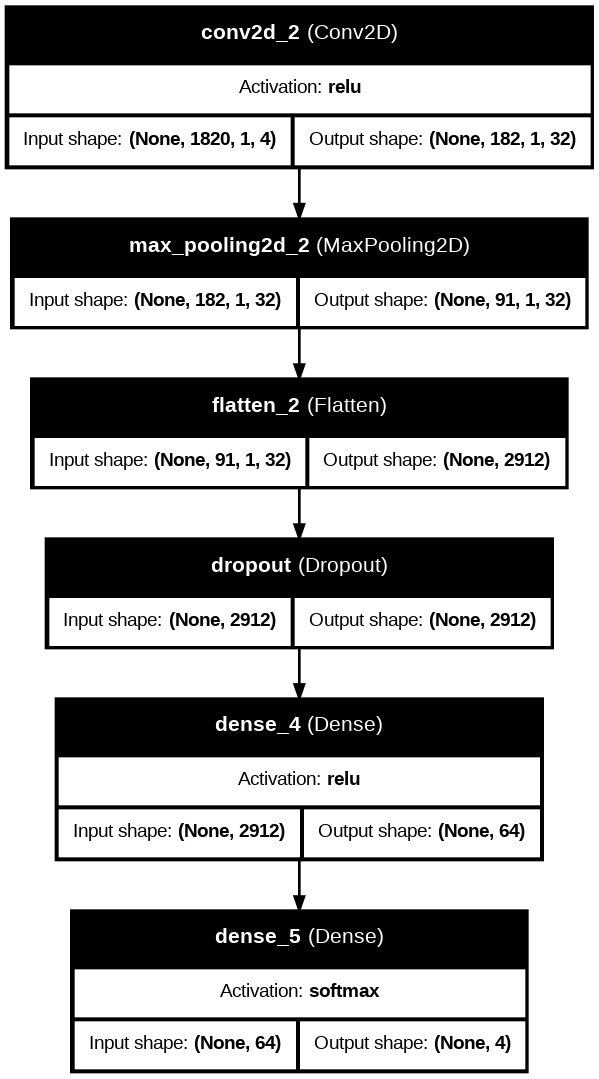

In [25]:
# prompt: visualize model architecture

!pip install pydot graphviz
!apt-get install graphviz -y

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

### Model Compilation - activation, learning rate, and metrics

In [26]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")



Model compiled successfully.


### Model Training

In [27]:
# --- 5. Train the Model ---
# Epochs: The number of times the training algorithm will work through the entire training dataset.
# Batch Size: The number of samples per gradient update. A typical value is 32 or 64.
# Validation Data: Pass the validation set (X_val, y_val) to monitor performance on unseen data during training.
epochs = 20
batch_size = 32 # You can experiment with different batch sizes

print(f"\nStarting training for {epochs} epochs with batch size {batch_size}...")

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

print("\nTraining finished.")

# You can access the training history using the 'history' object
# print(history.history) # This will print loss and accuracy for each epoch

# --- 6. Evaluate the Model (Optional but recommended) ---
# Evaluate the model on the test set (X_test, y_test) to get a final performance measure.
# print("\nEvaluating model on the test set...")
# loss, accuracy = model.evaluate(X_test, y_test)

# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")


Starting training for 20 epochs with batch size 32...
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4152 - loss: 1.2957 - val_accuracy: 0.7600 - val_loss: 1.0608
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7033 - loss: 0.9896 - val_accuracy: 0.9200 - val_loss: 0.7720
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8361 - loss: 0.7201 - val_accuracy: 0.9000 - val_loss: 0.5622
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9115 - loss: 0.5029 - val_accuracy: 0.9100 - val_loss: 0.4149
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9358 - loss: 0.3587 - val_accuracy: 0.9500 - val_loss: 0.3215
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9668 - loss: 0.2563 - val_accuracy: 0.9500 - val_loss: 0.2612
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9889 - loss: 0.2144 - val_accuracy: 0.9600 - val_loss: 0.2261
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc

In [28]:
#save the model

model.save('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model1.keras')


### Training and validation results and analysis

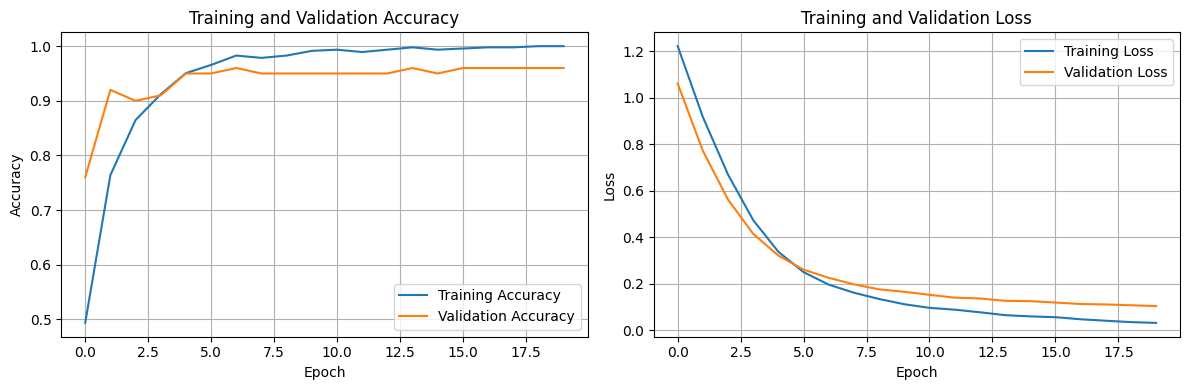

In [29]:
# prompt: plot training and validation loss and accuracy graphs

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Test evaluation and analysis

In [30]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model.keras')



In [31]:
# 1. Get predictions from the model
# model.predict returns probabilities for each class
y_pred_probabilities = model.predict(X_test)

# 2. Convert probabilities to predicted class labels
# np.argmax will give you the index of the highest probability
predicted_integer_labels = np.argmax(y_pred_probabilities, axis=1)

# 3. If you want to see the human-readable HA types,
# use the label_encoder to inverse transform the integer labels
predicted_ha_types = label_encoder.inverse_transform(predicted_integer_labels)

# 4. Get the true labels in human-readable format for comparison
true_integer_labels = np.argmax(y_test, axis=1) # Convert y_test back from one-hot to integer
true_ha_types = label_encoder.inverse_transform(true_integer_labels)

# 5. Print a sample of predictions vs. true labels
print("\n--- Sample of Predictions vs. True Labels ---")
for i in range(min(10, len(X_test))): # Print up to 10 samples
    print(f"Sample {i+1}:")
    print(f"  True HA Type: {true_ha_types[i]}")
    print(f"  Predicted HA Type: {predicted_ha_types[i]}")
    print(f"  Prediction Probabilities: {y_pred_probabilities[i]}")
    print("-" * 30)

# Overall model performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

--- Sample of Predictions vs. True Labels ---
Sample 1:
  True HA Type: HA7
  Predicted HA Type: HA7
  Prediction Probabilities: [0.23472579 0.11490628 0.06547044 0.5848974 ]
------------------------------
Sample 2:
  True HA Type: HA5
  Predicted HA Type: HA5
  Prediction Probabilities: [0.02759114 0.02356435 0.93560135 0.01324324]
------------------------------
Sample 3:
  True HA Type: HA1
  Predicted HA Type: HA1
  Prediction Probabilities: [0.7256522  0.06339649 0.16205528 0.04889604]
------------------------------
Sample 4:
  True HA Type: HA7
  Predicted HA Type: HA7
  Prediction Probabilities: [0.07377294 0.03818461 0.01705233 0.8709901 ]
------------------------------
Sample 5:
  True HA Type: HA1
  Predicted HA Type: HA1
  Prediction Probabilities: [0.97658277 0.00617607 0.00899008 0.0082511 ]
------------------------------
Sample 6:
  True HA Type: HA1
  Predicted HA Type: HA3
  Prediction Probabilities: [0.23402639 0.30801043 0.267285 

In [34]:
# prompt: please generate the above code, but i want the accession number of the samples

import pandas as pd
import numpy as np
# Access the cnn_accessions array
print("\n--- Accession Numbers ---")
print(cnn_accessions[:10])
print(f"Total number of accession numbers: {len(cnn_accessions)}")

# If you want to link accession numbers to the test set results:
# You need to split the cnn_accessions array along with the sequences and labels.
# The current splitting code only splits X and y. To get accession numbers
# corresponding to the test set, you need to split the accession numbers too.

# Assuming cnn_accessions corresponds row-wise to cnn_sequences and cnn_labels
# You would need to include cnn_accessions in the initial split.

# Re-do the splitting including accession numbers
# Note: train_test_split needs the same random_state and stratify argument
# to ensure the splits are aligned across X, y, and accessions.
X_reshaped = np.expand_dims(cnn_sequences, axis=2) # Keep the reshaping

# Add cnn_accessions to the split
X_train, X_temp, y_train, y_temp, acc_train, acc_temp = train_test_split(
    X_reshaped, one_hot_labels, cnn_accessions, test_size=0.3, random_state=42, stratify=one_hot_labels
)
X_val, X_test, y_val, y_test, acc_val, acc_test = train_test_split(
    X_temp, y_temp, acc_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTest set shape (Accessions): {acc_test.shape}")

# Now, when you iterate through the test set results, you can include the accession number
print("\n--- Sample of Predictions vs. True Labels with Accession Numbers ---")
for i in range(min(10, len(X_test))): # Print up to 10 samples
    print(f"Sample {i+1}:")
    print(f"  Accession Number: {acc_test[i]}") # Add accession number here
    print(f"  True HA Type: {true_ha_types[i]}")
    print(f"  Predicted HA Type: {predicted_ha_types[i]}")
    print(f"  Prediction Probabilities: {y_pred_probabilities[i]}")
    print("-" * 30)

# You can also create a pandas DataFrame to easily view test results
test_results_df = pd.DataFrame({
    'Accession': acc_test,
    'True_HA_Type': true_ha_types,
    'Predicted_HA_Type': predicted_ha_types
})

# Add prediction probabilities for each class
for i, class_name in enumerate(label_encoder.classes_):
    test_results_df[f'Prob_{class_name}'] = y_pred_probabilities[:, i]

print("\n--- Test Set Results DataFrame (first 10) ---")
display(test_results_df.head(10))

# To save the test results with accession numbers to a CSV file:
test_results_csv_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model1_test_results_with_accessions.csv'
test_results_df.to_csv(test_results_csv_path, index=False)
print(f"\nTest results saved to {test_results_csv_path}")


--- Accession Numbers ---
['NC_007366.1' 'MF673163.1' 'MG386182.1' 'KJ907511.1' 'KJ907519.1'
 'KJ907527.1' 'KJ907535.1' 'KJ907543.1' 'KJ907551.1' 'KJ907727.1']

Test set shape (Accessions): (101,)

--- Sample of Predictions vs. True Labels with Accession Numbers ---
Sample 1:
  Accession Number: KU585908.1
  True HA Type: HA7
  Predicted HA Type: HA7
  Prediction Probabilities: [0.23472579 0.11490628 0.06547044 0.5848974 ]
------------------------------
Sample 2:
  Accession Number: KP307976.1
  True HA Type: HA5
  Predicted HA Type: HA5
  Prediction Probabilities: [0.02759114 0.02356435 0.93560135 0.01324324]
------------------------------
Sample 3:
  Accession Number: KJ645761.1
  True HA Type: HA1
  Predicted HA Type: HA1
  Prediction Probabilities: [0.7256522  0.06339649 0.16205528 0.04889604]
------------------------------
Sample 4:
  Accession Number: KM244100.1
  True HA Type: HA7
  Predicted HA Type: HA7
  Prediction Probabilities: [0.07377294 0.03818461 0.01705233 0.8709901 ]

,Accession,True_HA_Type,Predicted_HA_Type,Prob_HA1,Prob_HA3,Prob_HA5,Prob_HA7
0,KU585908.1,HA7,HA7,0.234726,0.114906,0.065470,0.584897
1,KP307976.1,HA5,HA5,0.027591,0.023564,0.935601,0.013243
2,KJ645761.1,HA1,HA1,0.725652,0.063396,0.162055,0.048896
3,KM244100.1,HA7,HA7,0.073773,0.038185,0.017052,0.870990
4,KC859094.1,HA1,HA1,0.976583,0.006176,0.008990,0.008251
5,KF572616.1,HA1,HA3,0.234026,0.308010,0.267285,0.190678
6,KJ907599.1,HA5,HA5,0.023742,0.026407,0.933370,0.016480
7,JQ409142.1,HA1,HA1,0.977117,0.006494,0.008663,0.007726
8,KM392379.1,HA5,HA5,0.018467,0.030939,0.939723,0.010871
9,JQ431209.1,HA1,HA1,0.977785,0.005955,0.008521,0.007739



Test results saved to /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model1_test_results_with_accessions.csv


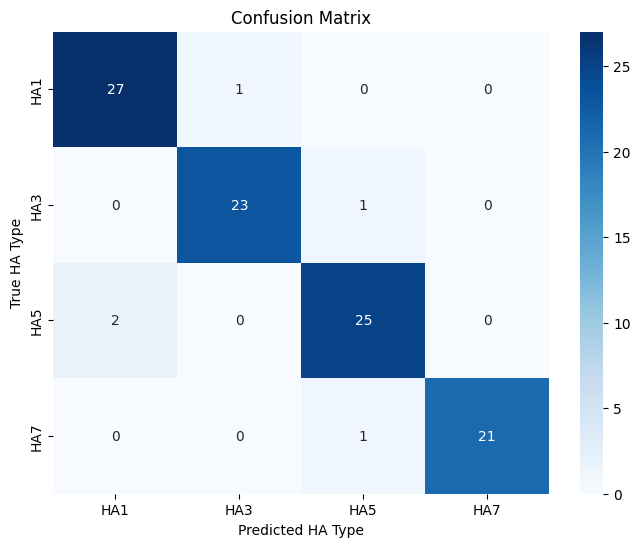


Confusion Matrix:


array([[27,  1,  0,  0],
       [ 0, 23,  1,  0],
       [ 2,  0, 25,  0],
       [ 0,  0,  1, 21]])

In [35]:
# confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
# confusion_matrix expects true integer labels and predicted integer labels
cm = confusion_matrix(true_integer_labels, predicted_integer_labels)

# Get the class names (HA types) from the label encoder
class_names = label_encoder.classes_

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted HA Type')
plt.ylabel('True HA Type')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
cm

### Observation

The wrongly 'predicted' ones have low percentage scores.

### (Extra) Activation Heatmap

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def get_feature_maps(model, layer_name, input_data):
    """
    Gets the feature maps (activations) from a specified layer in the model.

    Args:
        model (tf.keras.Model): The trained Keras model.
        layer_name (str): The name of the layer from which to extract feature maps.
        input_data (np.ndarray): The input data for which to get activations (e.g., a single sample).
                                 Shape should match the model's input shape (e.g., (1, height, width, channels)).

    Returns:
        np.ndarray: The feature maps from the specified layer. Returns None if the layer is not found.
    """
    try:
        # Create a model that outputs the activations of the specified layer
        feature_map_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=model.get_layer(layer_name).output
        )
    except ValueError:
        print(f"Error: Layer '{layer_name}' not found in the model.")
        print("Available layers:")
        for layer in model.layers:
            print(f"- {layer.name}")
        return None
    except Exception as e:
        print(f"Error creating feature map model: {e}")
        return None

    # Get the feature maps for the given input data
    feature_maps = feature_map_model.predict(input_data)

    return feature_maps

def visualize_feature_maps(feature_maps, num_to_visualize=8):
    """
    Visualizes a subset of feature maps.

    Args:
        feature_maps (np.ndarray): The feature maps to visualize.
                                   Shape: (batch_size, height, width, channels).
                                   We assume batch_size is 1 for visualizing a single sample.
        num_to_visualize (int): The maximum number of feature maps to display.
    """
    if feature_maps is None or feature_maps.shape[0] != 1:
        print("Invalid feature maps data for visualization.")
        return

    # Remove the batch dimension
    feature_maps = feature_maps[0] # Shape becomes (height, width, channels)

    # For our DNA sequence case, the shape is (sequence_length, 1, filters)
    # We need to squeeze the width dimension (axis 1) to get (sequence_length, filters)
    feature_maps = np.squeeze(feature_maps, axis=1) # Shape becomes (sequence_length, filters)

    num_filters = feature_maps.shape[-1]
    print(f"Visualizing up to {min(num_to_visualize, num_filters)} out of {num_filters} feature maps.")

    # Determine the layout for subplots (e.g., 2 rows, num_to_visualize/2 columns)
    display_grid = int(np.ceil(np.sqrt(min(num_to_visualize, num_filters))))
    fig, axes = plt.subplots(display_grid, display_grid, figsize=(8, 8))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i in range(min(num_to_visualize, num_filters)):
        ax = axes[i]
        # Display the i-th feature map.
        # Since it's (sequence_length, 1), we can treat it as an image.
        # Use aspect='auto' to fit the data.
        img = feature_maps[:, i] # Get the i-th filter's activations across the sequence
        im = ax.imshow(img[:, np.newaxis].T, cmap='viridis', aspect='auto', interpolation='nearest') # Reshape for imshow and transpose

        ax.set_title(f'Filter {i}')
        ax.axis('off') # Hide axes ticks and labels

        # Add a colorbar to each subplot
        fig.colorbar(im, ax=ax)


    # Hide any unused subplots
    for j in range(min(num_to_visualize, num_filters), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# --- Example Usage for Feature Map Visualization ---
# Assuming you have your trained 'model', 'X_test', and 'cnn_accessions'
# from the previous code run.

if 'model' in locals() and 'X_test' in locals() and 'cnn_accessions' in locals():
    # Choose a sample from the test set to visualize (e.g., the first one)
    sample_index_viz = 0
    single_input_sequence_viz = X_test[sample_index_viz:sample_index_viz+1] # Keep batch dimension (1, 1820, 1, 4)
    accession_viz = cnn_accessions[sample_index_viz]

    print(f"\nVisualizing feature maps for sample index {sample_index_viz} (Accession: {accession_viz})")

    # Specify the name of the convolutional layer you want to visualize
    # Make sure this layer name exists in your model (e.g., 'conv2d')
    target_layer_name = 'conv2d' # Or the name of your convolutional layer

    # Get the feature maps
    feature_maps = get_feature_maps(model, target_layer_name, single_input_sequence_viz)

    # Visualize a subset of the feature maps
    if feature_maps is not None:
        visualize_feature_maps(feature_maps, num_to_visualize=10) # Visualize 16 feature maps
    else:
        print(f"Could not get feature maps for layer '{target_layer_name}'.")

else:
    print("Required variables (model, X_test, cnn_accessions) not found.")
    print("Please ensure the previous code blocks were run successfully.")

### EXTRA: FUNCTION/CLASS FORM

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

class SequenceCNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(SequenceCNN, self).__init__()

        # Define layers
        self.conv1 = layers.Conv2D(64, kernel_size=(21, 1), strides=(10, 1), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 1))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output

# Example of how to use the object-oriented model:
# Assuming you have input_shape_for_conv2d and num_classes defined from previous steps

# Create an instance of the model
# object_oriented_model = SequenceCNN(num_classes)

# You can build the model by calling it with a dummy input with the correct shape
# object_oriented_model.build((None,) + input_shape_for_conv2d) # None for batch size

# Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# object_oriented_model.compile(optimizer=optimizer,
#                               loss='categorical_crossentropy',
#                               metrics=['accuracy'])

# Print the summary
# object_oriented_model.summary()